## This notebook serves as a basis for the KinoML workflow

### Premises

The aim is to be able to predict the binding free energy $\Delta g$ of a given molecule and a given target.

_**How ?**_ 

By building a ML and using physics-based models. 

### Challenges
There are several publicly available data sets of bioactivity. However, none of them directly report $\Delta g$.

### Workaround
Use physics informed models.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

import torch
import torch.nn as nn
import torch.nn.functional as F

### ChEMBL25 
We are going to use the EGFR data of ChEMBL v.25 as an example, but the idea can be applied to other data sets such as KinomeScan.

*Remark*: here ChEMBL25 reports the IC50/pIC50 value.

In [2]:
# Read the data
data = pd.read_csv("data/CHEMBL25_activities_EGFR.csv", index_col=0)
data.head()

,chembl_id,IC50,units,canonical_smiles,pIC50
1777,CHEMBL207869,77.0,nM,Fc1cccc(COc2ccc(Nc3ncncc3C#Cc4ncccn4)cc2Cl)c1,7.113509
5785,CHEMBL3940060,330.0,nM,Fc1ccc(Nc2ncnc3cc4OC(=O)N(CCOC(=O)CCl)c4cc23)c...,6.481486
6373,CHEMBL3678951,1.0,nM,CC(C)n1c(Nc2cccc(c2)C(F)(F)F)nc3cnc(Nc4ccc(cc4...,9.000000
2442,CHEMBL504034,40.0,nM,CS(=O)(=O)CCNC(=O)O[C@H]1CN[C@@H](C1)C#Cc2cc3n...,7.397940
1084,CHEMBL158797,43000.0,nM,Cn1c(SSc2c(C(=O)NCC(O)CO)c3ccccc3n2C)c(C(=O)NC...,4.366532


### Ligand featurization
Featurize the ligand.

Here we use the simple of example of the fingerprint, but any featurize available in KinoML could be applied (for example the graph featurizer).

In [3]:
def smiles_to_morgan_fp(smile, nbits=1024, radius=2):
    '''
    Convert a smile into Morgan fingerprint of radius 2 and length 1024 using RDKit.
    '''
    molecule = Chem.MolFromSmiles(smile)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, radius=radius, nBits=nbits)
    return np.array(fingerprint)

In [4]:
# Convert smiles to morgan fingerprint
data['morgan_fp'] = data['canonical_smiles'].apply(smiles_to_morgan_fp)

### Model
We build a shallow neural network with only one hidden layer. The output of the model is a single node, which represents $\Delta g$.

Here the model is very simple, but any model available in KinoML can be used (e.g. Graph Neural Network).

In [5]:
class NeuralNetworkRegression(nn.Module):
    """
    Builds a Pytorch model (a Dense Neural Network) and a feed-forward pass
    """
    def __init__(self, input_size=1024, hidden_size=100, output_size=1):
        super(NeuralNetworkRegression, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.fully_connected_1 = nn.Linear(self.input_size, self.hidden_size) # Fully connected layer 
        self.fully_connected_out = nn.Linear(self.hidden_size, self.output_size) # Output

    def forward(self, x):
        """
        Defines the foward pass for a given input 'x'
        """
        x = F.relu(self.fully_connected_1(x)) # Activations are ReLU
        return self.fully_connected_out(x)

In [6]:
model = NeuralNetworkRegression()
print(model)

NeuralNetworkRegression(
  (fully_connected_1): Linear(in_features=1024, out_features=100, bias=True)
  (fully_connected_out): Linear(in_features=100, out_features=1, bias=True)
)


### Define a loss function
Herer we use the mean squarred error as a loss, but a more complex function which can account for different measurement types will be used.

In [7]:
criterion = nn.MSELoss() # Mean squared error

### A few model settings and Pytorch tensors conversions

In [8]:
# Model setting
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
nb_epoch = 100

# Convert input/output to neural network to pytorch tensor
model_inputs = torch.tensor(list(data['morgan_fp'])).type(torch.FloatTensor)
targeted_measurements = torch.tensor(list(data['IC50'])).type(torch.FloatTensor)

### Idea behind the _physics-based_ function

As stated above, we would like to predict the (unitless) binding free energy $\Delta g$ which is not reported in public data sets. 

However there are physics-based models which relate measured quantities (such as $K_d$) to the desired $\Delta g$.

In order to use all available data and combine different data sets, for every measurement type, we define a function based on the physics that maps $\Delta g$ to the measured data type.

#### ChEMBL
The measurement types available in ChEMBL are:
- IC50
- $K_i$
- $K_d$

#### KinomeScan
The measurement type in KinomeScan is the percent displacement
- $\%displ.$

### Define a _physics-informed_ function to be applied on $\Delta g$

This _physics-informed_ function is adapted to each measurement type.

#### For $K_d$ measurements
We define the following physics-based function
$$
\mathbf{F}_{K_d}(\Delta g) = exp[-\Delta g] * 1[M].
$$

If we have measurements at different concentrations $I$ (unit [M]) , then the function can further be defined as

$$
\mathbf{F}_{K_d}(\Delta g, I) = exp[-\Delta g] * I[M].
$$

#### For $K_i$ measurements
We make the assumption that $K_i \approx K_d$ and therefore $\mathbf{F}_{K_i} = \mathbf{F}_{K_d}$.


#### For IC50 measurements
We use the Cheng Prusoff equation here.

The [Cheng Prusoff](https://en.wikipedia.org/wiki/IC50#Cheng_Prusoff_equation) equation states the following relationship

\begin{equation}
K_i = \frac{IC50}{1+\frac{[S]}{K_m}}
\end{equation}


We make the following assumptions here
1. $[S] = K_m$
2. $K_i \approx K_d$

In the future, we will relax these assumptions.

Under these assumptions, the Cheng-Prusoff equation becomes
$$
IC50 \approx 2 * K_d
$$

We define the following function
$$
\mathbf{F}_{IC50}(\Delta g) = 2 * \mathbf{F}_{K_d}(\Delta g) = 2 * exp[-\Delta g] * 1[M]
$$

#### For KinomeScan measurements 
For the percent displacement measurements available from KinomeScan, we make the assumption (see JDC's notes) that

$$
D([I]) \approx \frac{1}{1 + \frac{K_d}{[I]}}
$$

For KinomeSCAN assays, all assays are usually performed at a single concentration, $ [I] \sim 1 \mu M $.

We therefore define the following function
$$
\mathbf{F}_{KinomeScan}(\Delta g, [I]) = \frac{1}{1 + \frac{exp[-\Delta g] * 1[M]}{[I]}}.
$$

In [9]:
def physics_informed_IC50(delta_g, S=1, K_m=1,  I=1): 
    '''
    Physics based model for IC50 measurements
    '''
    return (1+S/K_m) * (torch.exp(-delta_g)*I)

In [10]:
def physics_informed_Kd(delta_g, I=1): 
    '''
    Physics based model for Kd measurements
    '''
    return torch.exp(-delta_g)*I

In [11]:
def physics_informed_Ki(delta_g, I=1): 
    '''
    Physics based model for Ki measurements
    
    Note
    For now, the same function as for Kd measurements.
    '''
    return torch.exp(-delta_g)*I

In [12]:
def physics_informed_kinomescan(delta_g, I):
    '''
    Physics based model for KinomeScan measurements
    '''
    return 1/(1+torch.exp(-delta_g)*1/I)

### Application

Apply physics-informed function to predicted $\Delta g$ and compute loss function w.r.t to the learnable parameters.

#### 1 iteration only
See below for several epochs

In [13]:
# Compute delta g using the model defined above and the featurized ligands
delta_g = model(model_inputs)

# Apply physics-informed function to the predicted delta g
prediction = physics_informed_IC50(delta_g)

# Obtain loss for the predicted output
loss = criterion(prediction, targeted_measurements)

# Gradients w.r.t to parameters
loss.backward()

/Users/TaliaKimber/.local/miniconda/envs/kinoml/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([3906])) that is different to the input size (torch.Size([3906, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [17]:
# Training loop

full_loss = []
for epoch in range(nb_epoch):

    # Clear gradients
    optimizer.zero_grad()

    # Obtain model prediction given model input
    delta_g = model(model_inputs)
    prediction = physics_informed_IC50(delta_g)

    # Obtain loss for the predicted output
    loss = criterion(prediction, targeted_measurements)
    full_loss.append(loss)

    # Gradients w.r.t to parameters
    loss.backward()

    # Optimizer
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'epoch {epoch} : loss {loss}')

epoch 0 : loss 415460753408.0
epoch 10 : loss 415402459136.0
epoch 20 : loss 415354552320.0
epoch 30 : loss 415314214912.0
epoch 40 : loss 415280005120.0
epoch 50 : loss 415248809984.0
epoch 60 : loss 415218925568.0
epoch 70 : loss 415192023040.0
epoch 80 : loss 415166136320.0
epoch 90 : loss 415141658624.0


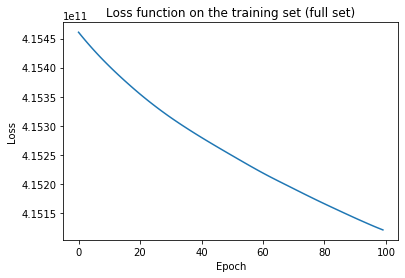

In [18]:
plt.figure()
plt.plot(full_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss function on the training set (full set)")
plt.show()

In [16]:
print(f"Max and min values of IC50 {min(data['IC50'])}, {max(data['IC50'])}")

Max and min values of IC50 0.004, 25000000.0


### Illustrative workflow

Workflow illustration with one measurement.

![unique_measurement](images/KinoML_Workflow-unique_measurement.png)

## Multiple data sets and measurements

When we have more than a single measurement type for a protein-ligand system, we can define a more complex loss function:

$$
L(\mathbf{\hat{y}}, \mathbf{y}) = 
\sum_{i=1}^{M} \alpha_i \cdot
\mathbf{1} \{ mse(\mathbf{\hat{y}_i}, \mathbf{y_i}) \text{ if assay type i exists}\},
$$ 
where the weight $\alpha_i$ would be determined according to the range of the different measurement types.

E.g.

$\alpha_{K_d} = \alpha_{K_i} = 1$ and $\alpha_{IC50} = 1/2$

### Illustrative workflow

Workflow illustration with multiple measurements

![multiple_measurements](images/KinoML_Workflow-multiple_measurements.png)